In [130]:
from pymongo import MongoClient
from pathlib import Path
import os
from pprint import pprint
import nltk
import matplotlib.pyplot as plt
import pprint
import pywt

import os
import struct
import matplotlib
from scipy import signal
import scipy.fftpack
import numpy as np
import sys
import pymongo
import json

import numpy as np
from scipy.signal import butter, lfilter, freqz
import matplotlib.pyplot as plt
%matplotlib inline

In [131]:
client = MongoClient('mongodb://localhost:27017')
testDb = client.testDb

patients = testDb.patients
sessions = testDb.sessions
reports = testDb.reports

In [132]:
def fileName(filePath):
    return (os.path.splitext(os.path.split(filePath)[1]))[0]

def fileExt(filePath):
    try:
        return (os.path.splitext(os.path.split(filePath)[1]))[1]
    except:
        return "Error"

In [133]:
class channel(object):
    def __init__(self,edfFile,label=None,transducer=None,dimensions=None,
                physMin=None,physMax=None,digMin=None,digMax=None,
                 preFilter=None,sampleRate=None,notes=None,channelIndex=None,byteLength=None):
        self.edfFile = edfFile
        self.label = str(label)
        self.sampleRate = int(sampleRate)
        self.transducer = str(transducer)
        self.dimensions = dimensions
        self.physMin = physMin
        self.physMax = physMax
        self.digMin = digMin
        self.digMax = digMax
        self.preFilter = preFilter
        self.notes  = notes
        self.channelIndex = int(channelIndex)
        self.byteLength = byteLength
        #self.indexStart = indexStart
    
    def __str__(self):
        if self.label==None:
            return "None"
        else:
            returnString = ("Label: "+str(self.label) + "\nSample Rate"+str(self.sampleRate)+
            "\nTransducer: "+str(self.transducer)+"\nDimensions: "+str(self.dimensions)+
            "\nphysMin: "+str(self.physMin)+"\nphysMax: "+str(self.physMax)+
            "\ndigMin: "+str(self.digMin) +"\ndigMax: "+str(self.digMax)+ "\npreFilter: "+str(self.preFilter)+
            "\nNotes: "+str(self.notes) + "\nChannelIndex: "+str(self.channelIndex) + "\nbyteLength: "+str(self.byteLength))
        return returnString
    
    def channelData(self,start,duration,channelNumber = 0,sensitivity = 1):
        '''
        Returns data points for desired area
        start: seconds from start of record
        duration: time  of record desired in seconds
        ##########This might be easier to do within original edf class
        Need to change to accomdate FLOATING POINTS !!!!!!!!!!!
        '''
        toReturn = []
        startByte = float(start) * self.sampleRate * 2
        '''
        print("TYPE START: ",type(start))
        print("channel.channelData Sample Rate: ",type(self.sampleRate))
        print("Start: ",start)
        print("START BYTE FROM CHANNEL DATA: ",startByte," Start: ",start," SampleRate: ",self.sampleRate)
        '''
        seekLocation = int(self.channelIndex + int(startByte))  #need to fix this --------------
        #print('Seek Location: ',seekLocation)
        numberOfBytes = int(self.sampleRate) * float(duration) #* 2
        try:
            numberOfBytes = int(numberOfBytes)
        except:
            return "ERROR in numberOfBytes"
        
        self.edfFile.edfRawData.seek(seekLocation)
        for i in range(numberOfBytes):
            try:
                value = struct.unpack('h',self.edfFile.edfRawData.read(2))[0]
                value = value*sensitivity    #Changed this from np.array(value)*sensitivity
                value -= channelNumber*20*sensitivity
            except:
                value = 'E'
            toReturn.append(value)
            #toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2))) 
        return toReturn

    def allChannelData(self):
        toReturn = []
        self.edfFile.edfRawData.seek(self.channelIndex)
        for i in range(int(self.byteLength/2)):
            toReturn.append(struct.unpack('h',self.edfFile.edfRawData.read(2)))
        return toReturn
        
    def getLabel(self):
        return str(self.label)
    
    def getSampleRate(self):
        return self.sampleRate
    
    def getChannelIndex(self):
        return self.channelIndex
    
    def getTransducer(self):
        return self.transducer

    def getDimensions(self):
        return self.dimensions
    
    def getPhysMin(self):
        return float(self.physMin)
    
    def getPhysMax(self):
        return float(self.physMax)
    
    def getDigMin(self):
        return float(self.digMin)
    
    def getDigMax(self):
        return float(self.digMax)
    
    def getPreFilter(self):
        return self.preFilter
    
    def getNotes(self):
        return self.notes
    
    def getByteLength(self):
        return self.byteLength
    
class edfData(object):
    def __init__(self,fileId):
        self.fileId=fileId
        
    def __str__(self):
        return ("version: " + str(self.version) + "\nPatient Id: "+str(self.patientId) 
                + "\nrecordId" + str(self.recordId) + "\nStart Date: " + str(self.startTime)
                + "\nStart Time: " + str(self.startTime)
                + "\nheader Bytes: " + str(self.headerBytes) +"\nReserve Bytes: " +str(self.reservedBytes)
                + "\nNum Records :" + str(self.nRecords) + "\nNum Signals :" + str(self.nSignals) 
                + "\nDuration: "+ str(self.duration) + "\nFile Size: "+str(self.fileSize))
                
                
    def loadFile(self,filepath):
        self.filePath = filepath
        self.fileSize = os.path.getsize(filepath)
        self.edfRawData = open(filepath,'rb')
        
    def readBitsTest(self):
        self.edfRawData.seek(0)
        bits = self.edfRawData.read(10000)
        self.edfRawData.seek(0)
        print(self.edfRawData.read(10))
        print("Some Bits: "+str(bits))
        return bits
    
    def readSignalHeaderBits(self,bitsIn,nSignals,nBits):
            returnArray = []
            for x in range(nSignals):
                returnArray.append(bitsIn.read(nBits))
            return returnArray
        
    def returnChannelObjects(self):
        return self.channels
    
    def parseEdf(self):
        '''
            This function parses the edf file getting the values of 
            the header fields. It also creates a channel object with 
            information about each channel, including the eeg tracing data from each channel.
        '''
        #Header Fields
        self.version = str(self.edfRawData.read(8))
        self.patientId = str(self.edfRawData.read(80))
        self.recordId = str(self.edfRawData.read(80))
        self.startDate = str(self.edfRawData.read(8))
        self.startTime = str(self.edfRawData.read(8))
        self.headerBytes = int(self.edfRawData.read(8))
        self.reservedBytes = str(self.edfRawData.read(44))
        self.nRecords = int(self.edfRawData.read(8))
        self.duration = float(self.edfRawData.read(8))
        self.nSignals = int(self.edfRawData.read(4))
        
        #Create channel object for each channel
        self.channels = {}
        channelFields = ['labels','transducer','dimensions','physMin','physMax','digMin','digMax',
                        'preFilter','sampleRate','reservedNotes']
        self.channels['labels'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,16)
        self.channels['transducer'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,80)
        self.channels['dimensions'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['physMin'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['physMax'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['digMin'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['digMax'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['preFilter'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,80)
        self.channels['sampleRate'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,8)
        self.channels['reservedNotes'] = self.readSignalHeaderBits(self.edfRawData,self.nSignals,32)
        
        self.channelObjects = []
        self.sampleRate = int(self.channels['sampleRate'][0])
        channelDataStart = self.headerBytes
        
    
        #This loop creates and adds channel objects to self.channelObjects
        for i in range(int(self.nSignals)):
            
            channelValues ={'filepath':self.filePath}
            byteLength = int(self.channels['sampleRate'][i])*self.nRecords     #*2
            channelIndex = channelDataStart
            channelDataStart +=byteLength
            
            for j in channelFields:
                try:
                    channelValues[j]=(self.channels[j][i])
                except:
                    channelValues[j] = None
            self.channelObjects.append(
                channel(self,channelValues['labels'],channelValues['transducer'],
                        channelValues['dimensions'],channelValues['physMin'],channelValues['physMax'],
                        channelValues['digMin'],channelValues['digMax'],channelValues['preFilter'],
                        channelValues['sampleRate'],channelValues['reservedNotes'],
                        channelDataStart,byteLength))  #Changed this channelIndex to channelDataStart
    
    
        self.channelSampleRates = channelValues['sampleRate'] 
        self.channelDigMax = channelValues['digMax']
        self.channelDigMin = channelValues['digMin']
        self.channelPhysMax = channelValues['physMax']
        self.channelPhysMin = channelValues['physMin']
            
    def data(self,start,duration):
        sampleData = []
        j = 0
        for x in self.channelObjects:
            sampleData.append([x.getLabel(),x.channelData(start,duration)])
            j+=1
        return sampleData
    
    def dataDictionary(self,start,duration):
        sampleData = {}
        j = 0
        #Returns dictionary with key being channel label, values being a dict [data,sampleRate,digMax,digMin,physMax,physMin]
        for x in self.channelObjects:
            sampleData[x.getLabel()]={'data':x.channelData(start,duration),'sampleRate':x.getSampleRate(),
                                     'digMax':x.getDigMax(),'digMin':x.getDigMin(),'physMin':x.getPhysMin(),
                                     'physMax':x.getPhysMax()}
            #print(x)
            j+=1
        return sampleData
    
    def dataForGraph(self,start,duration,sensitivity=1):
        sampleData = []
        j=0
        for x in self.channelObjects:
            sampleData.append([x.getLabel(),x.channelData(start,duration,j,sensitivity)])
            j+=1
        return sampleData
    
    def allData(self):
        '''
        Return[sampleRate,{channelData}]
        '''
        channelData = {}
        for x in self.channelObjects:
            channelData[str(x.getLabel())]=x.allChannelData()
        return[int(self.sampleRate),channelData]
            
            
    
    def patientId(self):
        return self.patientId
    
    def recordId(self):
        return self.recordId
    
    def startDate(self):
        return self.startDate
    
    def startTime(self):
        return self.startTime
    
    def headerBytes(self):
        return self.headerBytes
    
    def reservedBytes(self):
        return self.reservedBytes
    
    def duration(self):
        return self.duration
    
    def nRecords(self):
        return self.nRecords
    
    def numSignals(self):
        return self.nSignals
    
    def getSampleRate(self):
        return int(self.sampleRate)

    def channelLabels(self):
        labels = []
        for channel in self.channelObjects:
            labels.append(channel.label())
        return labels
    
    def totalSamples(self):
        duration = int(self.sampleRate) * int(self.nRecords)
        return duration
    
    def testChannelPrint(self):
        print(self.channelObjects[2])

In [211]:
'''
Plotting Functions
'''
    
    
def plotEDF(edfObject,montageArray,startPlot,endPlot,maxIndexMarkers=False):
    edfDataDictionary = edfObject.dataDictionary(startPlot,endPlot)
    dataDictionaryKeys = list(edfDataDictionary.keys())
    
    for i,x in enumerate(montageArray):
        channel1 = x[0]
        channel2 = x[1]
        channel1Label = dataDictionaryKeys[channel1]
        channel2Label = dataDictionaryKeys[channel2]
        
        channel1DigMax = edfDataDictionary[channel1Label]['digMax']
        channel1PhysMax = edfDataDictionary[channel1Label]['physMax']
        channel2DigMax = edfDataDictionary[channel1Label]['digMax']
        channel2PhysMax = edfDataDictionary[channel1Label]['physMax']
        
        channel1ScaleFactor = channel1PhysMax/channel1DigMax
        channel2ScaleFactor = channel2PhysMax/channel2DigMax
        
        input1Data = np.array(edfDataDictionary[channel1Label]['data']) * channel1ScaleFactor
        input2Data = np.array(edfDataDictionary[channel2Label]['data']) * channel2ScaleFactor
        
        plotData = input1Data - input2Data

        scaledAndMoved = plotData +(-i*600)
        channelAverageHeight = np.average(scaledAndMoved)
        
        channelsInMontage = len(montageArray)
        vLineHeight = 1/channelsInMontage
        
        if maxIndexMarkers == True:
            channelMax = max(plotData)
            maxIndex = list(plotData).index(channelMax)
            lineStart = 1-((i+2)*(vLineHeight))
            lineEnd = 1-(i*vLineHeight)
            plt.text(maxIndex,channelAverageHeight+60,("Index: "+str(maxIndex)+" Value: "+str(channelMax)))
            #plt.axes().axvline(maxIndex,i*vLineHeight,(i+1)*vLineHeight).set_color('green') This one is if plots aren't started from the bottom
            plt.axes().axvline(maxIndex,lineStart,lineEnd).set_color('green')

        #plt.text(maxIndex,channelAverageHeight+60,("Channel: ",str(x)," Max Index: ",str(maxIndex)))
        plt.text(0,channelAverageHeight+60,(str(channel1Label)+" - "+str(channel2Label)))
        plt.plot(scaledAndMoved)

    plt.show()
    
    
def plotQuadrantSpike(edfObject,quadrantArray,montageArray,quadrantToPlot,indexToPlot,timeSpan):
    '''
    Plot quadrant spike at specified index and quadrant
    '''
    sampleRate = edfObject.getSampleRate()
    startSecond = indexToPlot/sampleRate
    vLineLocation = sampleRate/2
    edfDataDictionary = edfObject.dataDictionary(startSecond,timeSpan)
    dataDictionaryKeys = list(edfDataDictionary.keys())
    quadrantChannels = quadrantArray[quadrantToPlot]
    for i,x in enumerate(quadrantChannels):
        channel1 = montageArray[x][0]
        channel2 = montageArray[x][1]
        channel1Label = dataDictionaryKeys[channel1]
        channel2Label = dataDictionaryKeys[channel2]
        
        channel1DigMax = edfDataDictionary[channel1Label]['digMax']
        channel1PhysMax = edfDataDictionary[channel1Label]['physMax']
        channel1SampleRate = edfDataDictionary[channel1Label]['sampleRate']
        channel2DigMax = edfDataDictionary[channel1Label]['digMax']
        channel2PhysMax = edfDataDictionary[channel1Label]['physMax']
        
        channel1ScaleFactor = channel1PhysMax/channel1DigMax
        channel2ScaleFactor = channel2PhysMax/channel2DigMax
        input1Data = np.array(edfDataDictionary[channel1Label]['data']) * channel1ScaleFactor
        input2Data = np.array(edfDataDictionary[channel2Label]['data']) * channel2ScaleFactor
        
        plotData = input1Data - input2Data

        scaledAndMoved = plotData +(-i*600)
        channelAverageHeight = np.average(scaledAndMoved)
        plt.axes().axvline(vLineLocation,0,1).set_color('red')
        plt.text(0,channelAverageHeight+60,(str(channel1Label)+" - "+str(channel2Label)))
        plt.plot(scaledAndMoved)
    plt.show()
        
        

In [135]:
'''
Global Variables
'''

#Longitudinal Bipolar Montage array
longBipolarMontage = [[0,10],[10,12],[12,14],[14,8],[0,2],[2,4],[4,6],[6,8],
                      [18,19],[19,20],[0,3],[3,4],[4,7],[7,9],[1,11],[11,13],[13,15],[15,9]] 

#adjacentElectrodeArray is an array of arrays where each of the entries is a quadrant LAQ,LPQ,RAQ,RPQ
adjacentElectrodeArray = [[0,1,4,5],[2,6,3,7],[10,11,14,15],[12,11,13,17]] 

#Contains Many Spikes
trainingFile1 ='/Users/taylorsomma/Desktop/capstone/v1.2.0/eval/01_tcp_ar/00009842/s001_2013_04_01/00009842_s001_t000.edf'

trainingEDF1 = edfData(1)
trainingEDF1.loadFile(trainingFile1)
trainingEDF1.parseEdf()
print(trainingEDF1)


version: b'0       '
Patient Id: b'00009842                                                                        '
recordIdb'Startdate 01-APR-2013 00009842_s001                                             '
Start Date: b'14.17.46'
Start Time: b'14.17.46'
header Bytes: 9472
Reserve Bytes: b'EDF                                         '
Num Records :1568
Num Signals :36
Duration: 1.0
File Size: 25890880


In [ ]:
keepPlotting = 1
while keepPlotting != -1:
    keepPlotting = input()
    plotStart = int(keepPlotting)
    plotEnd = int(plotStart+10)
    plt.figure(figsize=(20,10))
    plotEDF(trainingEDF1,longBipolarMontage,plotStart,plotEnd,True)

In [61]:
'''
Signal Processing Functions
'''

def getChangeArray(inputArray):
    newArray =[]
    for i in range(len(inputArray)):
        if i==0:
            pass
        newArray.append(inputArray[i]-inputArray[i-1])
    return newArray

def movingAverage(inputArray,avgNum):
    newArray = []
    for i in range(len(inputArray)):
        if i<avgNum:
            pass
        newArray.append(np.average(inputArray[i-(avgNum):i]))
    return newArray

def returnVariation(eegData,width,sampleRate):
    #Looks for greatest change over the specified width in the signal
    #width is samples to 
    v1 = eegData[0]
    totalChange = 0 
    maxChange = 0
    maxIndex = 0
    dataLength = len(eegData)
    for i in range(dataLength-width):
        currentChange = 0
        for j in range(width-1):
            currentChange += eegData[j+i]-eegData[j+i+1]
             
        if abs(currentChange) > abs(maxChange):
            maxChange = currentChange
            maxIndex = i
        #print(currentChange)
        currentChange = 0
        
    msTime = maxIndex/sampleRate
    #print("Max Change: ",maxChange," Max Index: ",maxIndex," Max Time: ",msTime)
    return [maxChange,maxIndex,msTime]

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff,btype='high', analog = False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order = 5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def range_filter(data, low, high, fs, order = 5):
    dataLow = butter_lowpass_filter(data,high,fs,order)
    dataReturn = butter_highpass_filter(dataLow,low,fs,order)
    return dataReturn
    

def zeroAverage1(data):
    average = np.mean(np.absolute(data))
    returnData = []
    for x in data:
        returnData.append(((x-average)/average)**2)
    return returnData

def normalizeSignal(data):
    maxValue = max(data)
    minValue = min(data)
    valueRange = maxValue-minValue
    returnArray = []
    for x in data:
        returnArray.append(x/valueRange)
    return returnArray
        

In [190]:
def lookForPossibleChannelSpikes(edfObject,montageArray,stepSize,searchSize,ampThreshold,ptpThreshold,durationToCheck,filterTag=False,loFilter=1,highFilter=40):
    '''
    data should already be scaled 
    stepSize: in mSec
    searchSize: in seconds
    ampThreshold: ratio of max to average
    returns: Dictionary {MontageChannelIndex:[spikeIndices]}
    '''
    
    edfDataDictionary = edfObject.dataDictionary(0,durationToCheck)
    dataDictionaryKeys = list(edfDataDictionary.keys())
    possibleSpikeDictionary = {}
    for i,channel in enumerate(montageArray):
        channel1Index = channel[0]
        channel2Index = channel[1]
        channel1Label = dataDictionaryKeys[channel1Index]
        channel2Label = dataDictionaryKeys[channel2Index]
        channel1 = edfDataDictionary[channel1Label]
        channel2= edfDataDictionary[channel2Label]
        
        channel1DigMax = channel1['digMax']
        channel1PhysMax = channel1['physMax']
        channel2DigMax = channel2['digMax']
        channel2PhysMax = channel2['physMax']
        sampleRate = channel1['sampleRate']
        
        channel1ScaleFactor = channel1PhysMax/channel1DigMax
        channel2ScaleFactor = channel2PhysMax/channel2DigMax
        
        input1Data = np.array(edfDataDictionary[channel1Label]['data']) * channel1ScaleFactor
        input2Data = np.array(edfDataDictionary[channel2Label]['data']) * channel2ScaleFactor
        
        channelData = input1Data - input2Data    
        
        sampleSearchSize = searchSize * sampleRate  #Size to search in each iteration
        stepSampleSize = int((stepSize/1000)*sampleRate)  #samples to move during each step
        totalSamples = durationToCheck * sampleRate  #Total Number of samples to check in data file
        numberOfSteps = int(totalSamples/stepSampleSize) #Total number of steps to take
        
        #print("SampleSearchSize: ",sampleSearchSize,"\nstepSampleSize: ",stepSampleSize,
        #    "\ntotalSamples: ",totalSamples,"\nnumberOfSteps: ",numberOfSteps)
    
        possibleSpikeArray = []
        
        for x in range(numberOfSteps):
            startIndex = x*stepSampleSize
            endIndex = (x*stepSampleSize)+sampleSearchSize
            segmentToCheck = channelData[startIndex:endIndex]
            segmentMax = np.amax(np.absolute(segmentToCheck))
            segmentPTP = np.ptp(segmentToCheck)
            segmentAverage = abs(np.average(segmentToCheck))
            #print("StartIndex: ",startIndex,"\nEndIndex: ",endIndex)
            freqs, pxx = scipy.signal.periodogram(segmentToCheck, sampleRate)
            amplitudeThreshold = segmentAverage * ampThreshold
            ptpThreshold = segmentAverage * ptpThreshold
            #print("AmplitudeThreshold: ",amplitudeThreshold,"\nSegment Max: ",segmentMax,"\nSegmentPTP: ",segmentPTP,
            #     "\nSegmentAverage: ",segmentAverage)
            if segmentMax > amplitudeThreshold and segmentPTP > amplitudeThreshold:
                try:
                    possibleSegmentIndex = list(segmentToCheck).index(segmentMax)
                except:
                    possibleSegmentIndex = list(segmentToCheck).index(0-segmentMax)
                    
                channelSpikeIndex = startIndex + possibleSegmentIndex
                if channelSpikeIndex not in possibleSpikeArray: 
                    possibleSpikeArray.append(channelSpikeIndex)
        
        possibleSpikeDictionary[i] = possibleSpikeArray
    return possibleSpikeDictionary
                    
                    
    


def checkQuadrants(indexDict,adjacencyArray,edfObject,latencyAllowed):
    '''
    adjacencyArray: list of lists containing channel indices in quadrant
    indexDict: {channelNumber:[spikeCandidates]}
    latencyAllowed: latency in mSec allowed
    
    returns: List of Lists containing possible spikes indices in each quadrant
    '''
    spikeCandidatesFinal = []
    sampleRate = edfObject.getSampleRate()
    spikeDistanceAllowed = latencyAllowed/sampleRate
    for quadrant in adjacencyArray:
        quadrantCandidates = []
        for channelIndex in quadrant: 
            for spikeIndex in indexDict[channelIndex]:
                quadrantCandidates.append(spikeIndex)
        #print("Quadrant1:",len(quadrantCandidates))
        isolatesRemoved = removeIsolatedSpikes(sampleRate,quadrantCandidates,latencyAllowed)
        spikeCandidatesFinal.append(isolatesRemoved)
    return spikeCandidatesFinal
                
                

def removeIsolatedSpikes(sampleRate,quadrantSpikesIn,latencyAllowedIn):
    '''
    Run this only in checkQuadrants!
    indexArray: Array of indices of possible spikes in a quadrant
    sampleRate: sampleRate of data
    latencyAllowed: distance between possible spikes in msec
    
    To do: Add adjacency coefficient
    '''
    returnList = []
    #print("LEN in",len(quadrantSpikesIn))
    quadrantSpikesIn.sort() 
    numberOfSpikes = len(quadrantSpikesIn)
    indexDistanceLimit = (latencyAllowedIn/1000) * sampleRate
    for i in range(numberOfSpikes-2):
        if i ==0:
            pass
        else:
            distanceLeft = abs(quadrantSpikesIn[i]-quadrantSpikesIn[i+1])
            distanceRight = abs(quadrantSpikesIn[i]-quadrantSpikesIn[i-1])
            if distanceLeft > indexDistanceLimit and distanceRight > indexDistanceLimit:
                pass
                #print("Removed, no adjaceny")
            else:
                returnList.append(quadrantSpikesIn[i])
    return returnList
            

def removeCloseSpikes(indexArray,edfObject,minDistanceBetweenSpikes):
    '''
    indexArray: Array of indices of possible spikes in a quadrant
    sampleRate: sampleRate of data
    latencyAllowed: distance between possible spikes in msec
    '''
    edfSampleRate = edfObject.getSampleRate()
    indexArray.sort()
    latencySamplesAllowed = (minDistanceBetweenSpikes/1000) * edfSampleRate
    returnArray = []
    indexLength = len(indexArray)
    removed = 0
    for i, x in enumerate(indexArray):
        sampleDistance = 1
        if i <= 1:
            returnArray.append(x)
        else:
            returnLength = len(returnArray)
            if (x-returnArray[returnLength-1]) > latencySamplesAllowed:
                returnArray.append(x)
            else:
                removed+=1
    #print("Removed: ",removed)
    return returnArray

def checkInput():
    a = input()
    a = int(a)
    if int(a)==0 or int(a)==1:
        return int(a)
    checkInput()

In [191]:
#lookForPossibleChannelSpikes(edfObject,montageArray,stepSize,searchSize,ampThreshold,ptpThreshold,durationToCheck,filterTag=False,loFilter=1,highFilter=40)
possibleSpikesPrelim = lookForPossibleChannelSpikes(trainingEDF1,longBipolarMontage,150,1,2,3,120,filterTag=False,loFilter=1,highFilter=40)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:55: RuntimeWarning: overflow encountered in double_scalars


In [197]:
print(possibleSpikesPrelim.keys())
for x in range(16):
    #print(len(possibleSpikesPrelim[x]))
    possibleSpikesPrelim[x]=removeCloseSpikes(possibleSpikesPrelim[x],trainingEDF1,300)
    #print("prelim elim: ",len(possibleSpikesPrelim[x]))
    
finalCandidatesB = checkQuadrants(possibleSpikesPrelim,adjacentElectrodeArray,trainingEDF1,20)
finalCandidates = []
for x in finalCandidatesB:
    #print(len(x))
    finalCandidates.append(removeCloseSpikes(x,trainingEDF1,300))
    
for y in finalCandidates:
    print("FINAL LEN: ",len(y))
    print(y)

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17])
FINAL LEN:  108
[492, 497, 1087, 1234, 1645, 1914, 2161, 2414, 2733, 3497, 3749, 3870, 3984, 5367, 5643, 5979, 6097, 6376, 6611, 6736, 7390, 7532, 7747, 8199, 8450, 8696, 9535, 9944, 10148, 10301, 10445, 10695, 10973, 11442, 11593, 11866, 11967, 12046, 12207, 12328, 12749, 12870, 13297, 13563, 14280, 14805, 14960, 15123, 15209, 15575, 16227, 16711, 16961, 17214, 17313, 17446, 17712, 18117, 18218, 18299, 18509, 18595, 18749, 19026, 19274, 19817, 19933, 20055, 20222, 20324, 20437, 20617, 20896, 21065, 21456, 21568, 21846, 21944, 22212, 22295, 22424, 22666, 22766, 23181, 23497, 23718, 23990, 24072, 24503, 24842, 25435, 25725, 25989, 26481, 26801, 27074, 27692, 27980, 28063, 28300, 28551, 28650, 28771, 29105, 29399, 29509, 29718, 29970]
FINAL LEN:  99
[195, 195, 567, 662, 1180, 1339, 2107, 2526, 3087, 3394, 3496, 3837, 3977, 4496, 4730, 5009, 5126, 5452, 5553, 6031, 6286, 7035, 7151, 7412, 7577, 7908, 8066, 8162, 832

Spike Index:  492


/Applications/anaconda3/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)


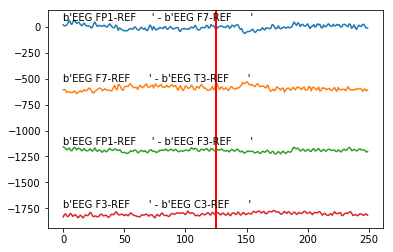

Spike Index:  497


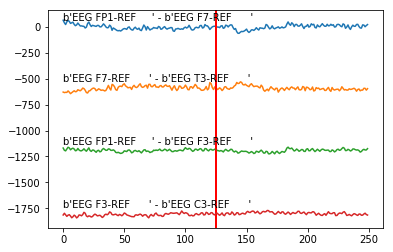

Spike Index:  1087


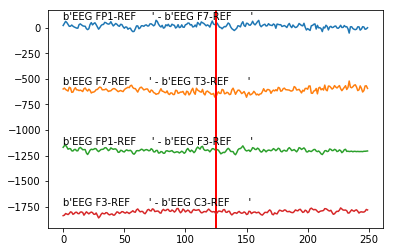

Spike Index:  1234


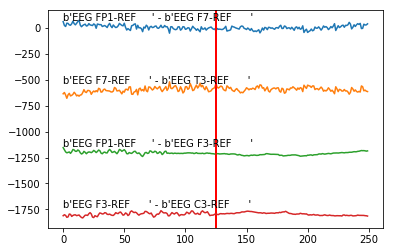

Spike Index:  1645


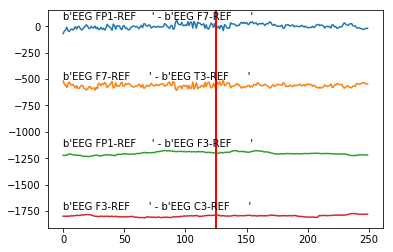

Spike Index:  1914


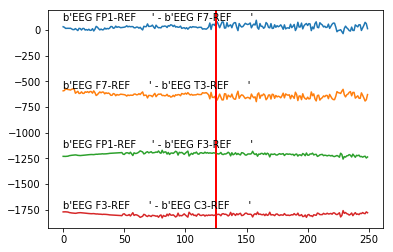

Spike Index:  2161


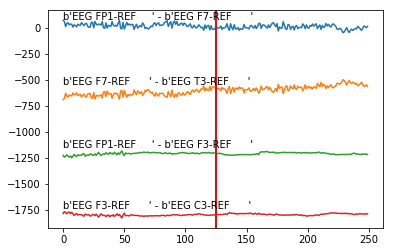

Spike Index:  2414


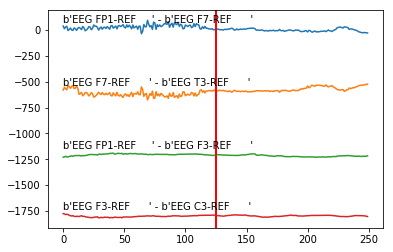

Spike Index:  2733


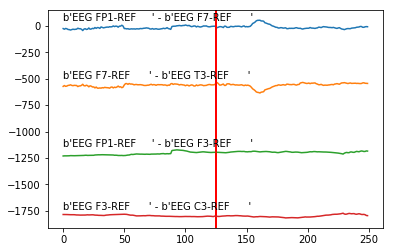

Spike Index:  3497


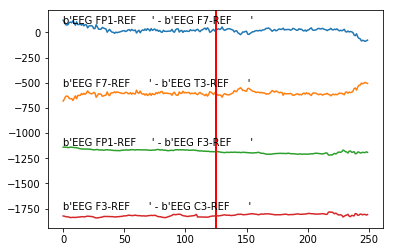

Spike Index:  3749


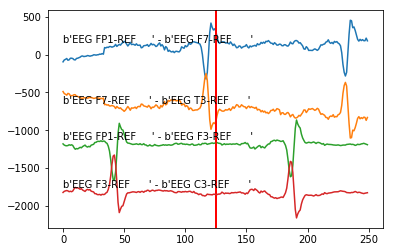

Spike Index:  3870


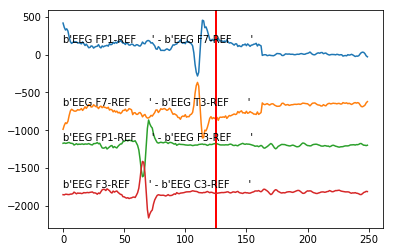

Spike Index:  3984


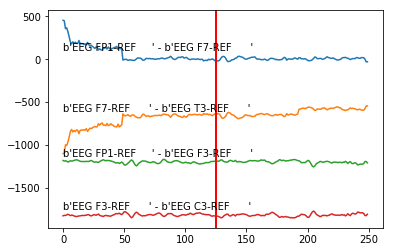

Spike Index:  5367


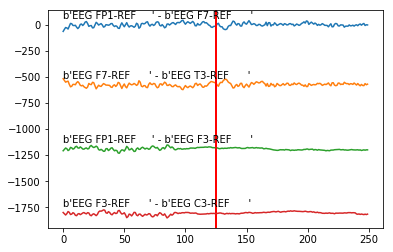

Spike Index:  5643


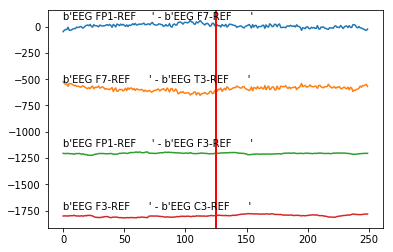

Spike Index:  5979


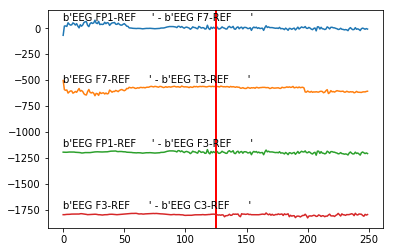

Spike Index:  6097


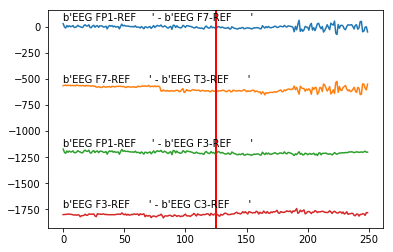

Spike Index:  6376


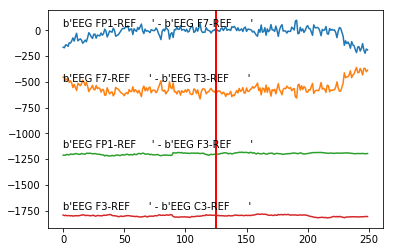

Spike Index:  6611


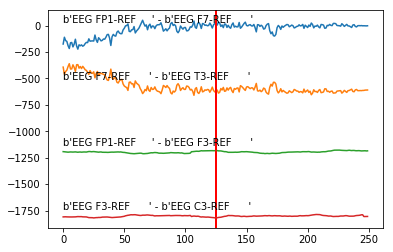

Spike Index:  6736


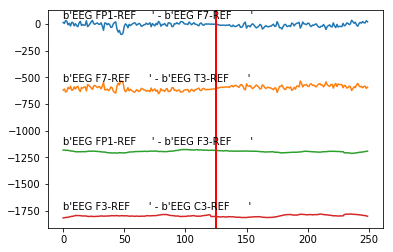

Spike Index:  195


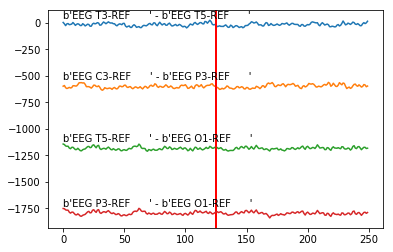

Spike Index:  195


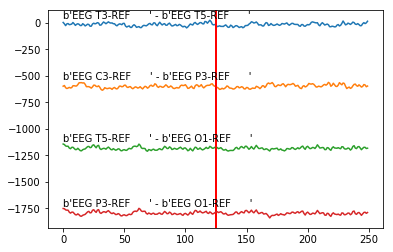

Spike Index:  567


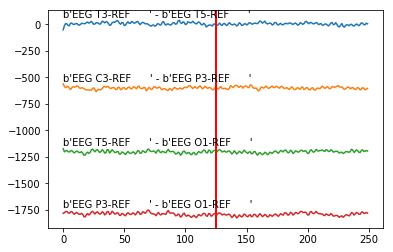

Spike Index:  662


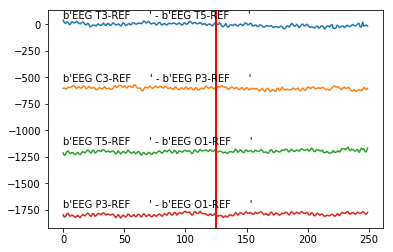

Spike Index:  1180


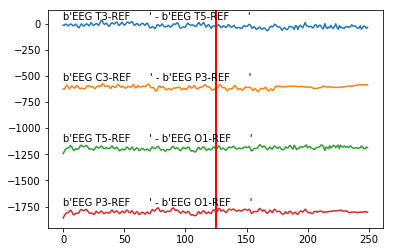

Spike Index:  1339


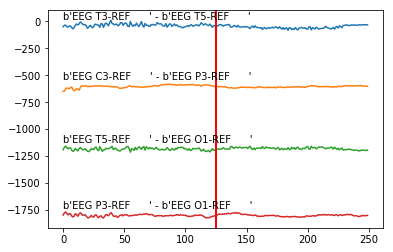

Spike Index:  2107


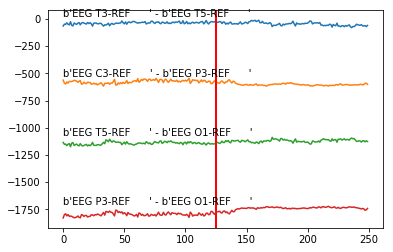

Spike Index:  2526


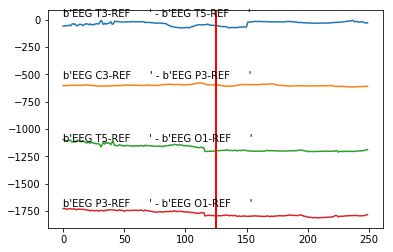

Spike Index:  3087


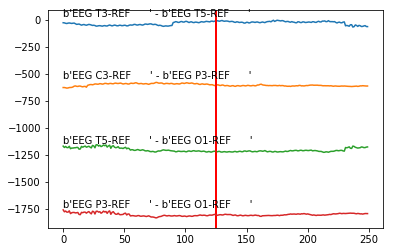

Spike Index:  3394


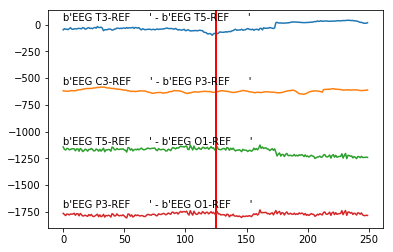

Spike Index:  3496


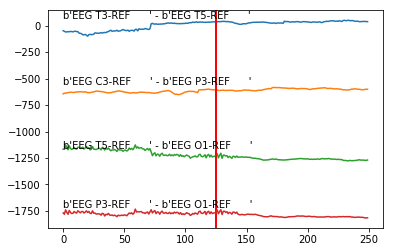

Spike Index:  3837


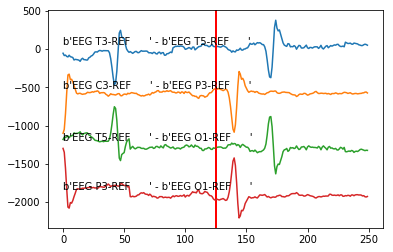

Spike Index:  3977


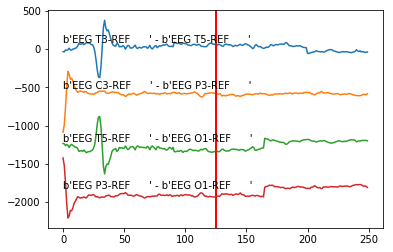

Spike Index:  4496


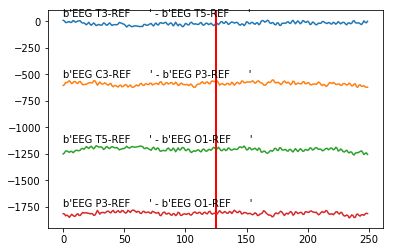

Spike Index:  4730


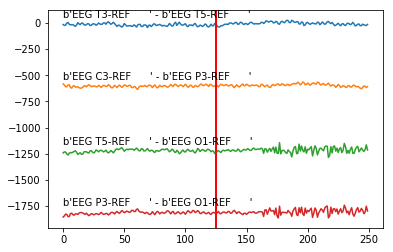

Spike Index:  5009


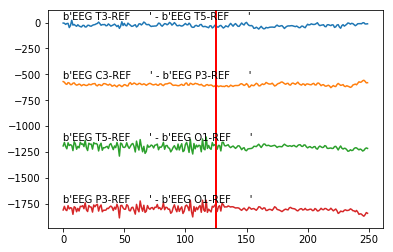

Spike Index:  5126


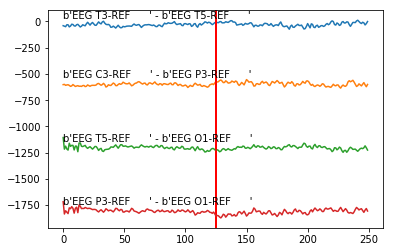

Spike Index:  5452


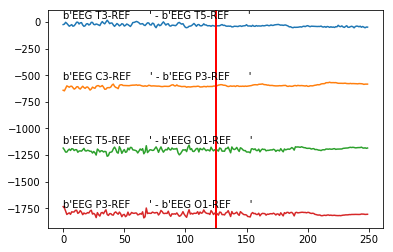

Spike Index:  5553


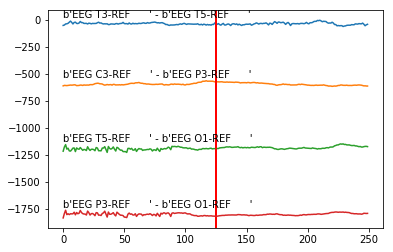

Spike Index:  6031


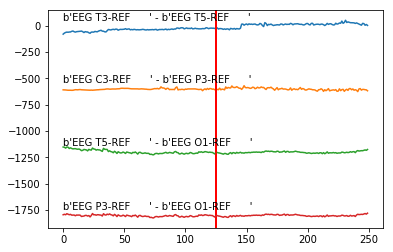

Spike Index:  487


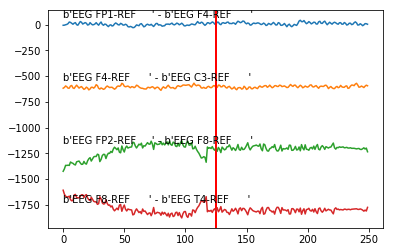

Spike Index:  487


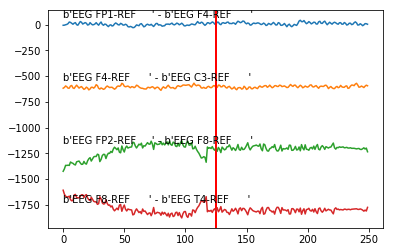

Spike Index:  604


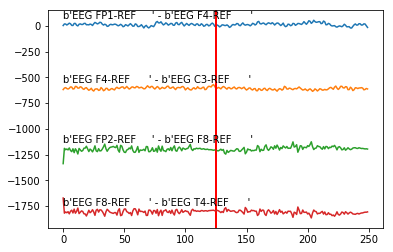

Spike Index:  807


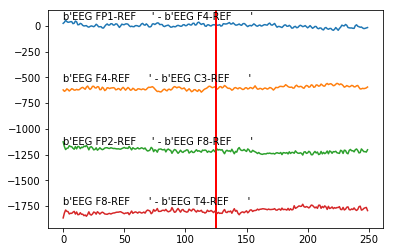

Spike Index:  1003


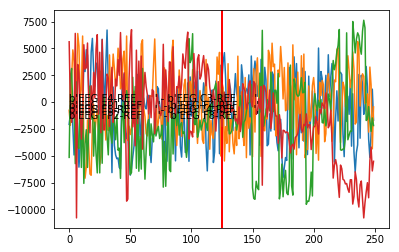

Spike Index:  1532


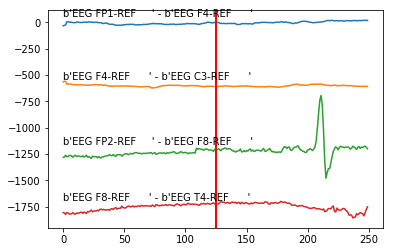

Spike Index:  2105


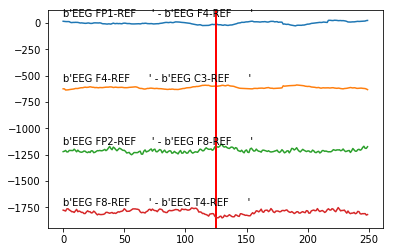

Spike Index:  2235


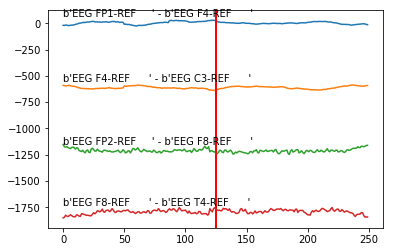

Spike Index:  3012


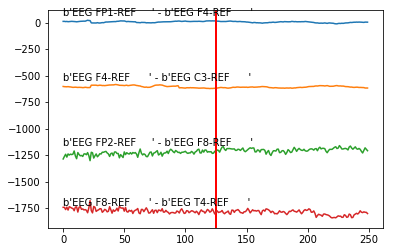

Spike Index:  3358


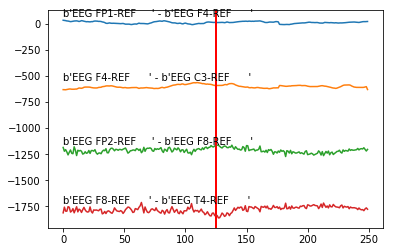

Spike Index:  4243


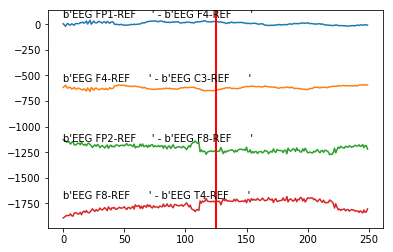

Spike Index:  4359


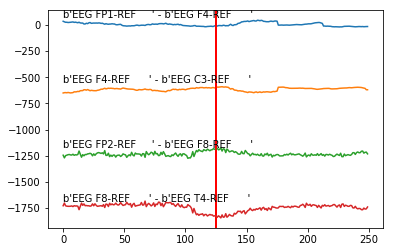

Spike Index:  4515


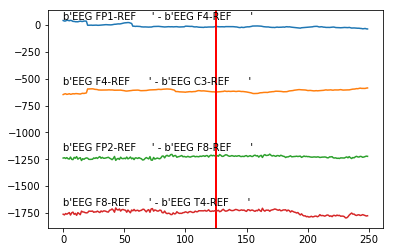

Spike Index:  4920


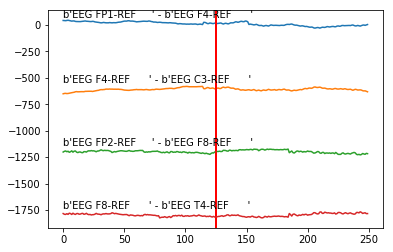

Spike Index:  5380


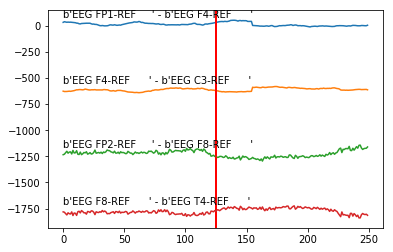

Spike Index:  5460


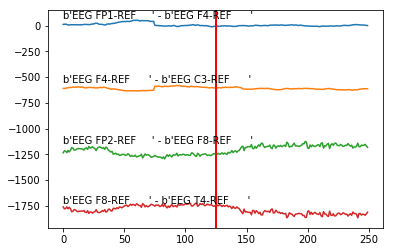

Spike Index:  5735


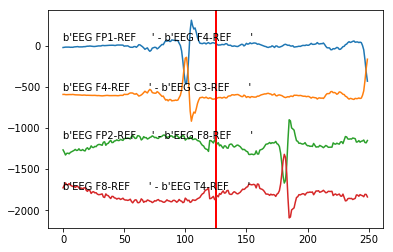

Spike Index:  5836


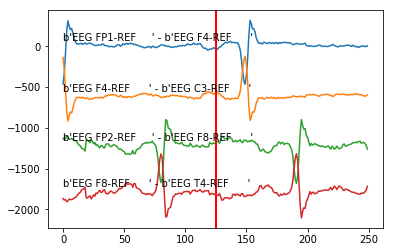

Spike Index:  5916


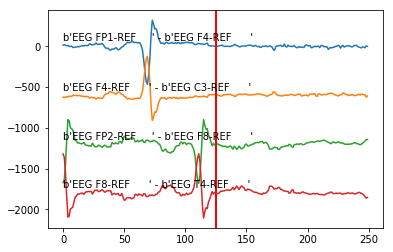

Spike Index:  6027


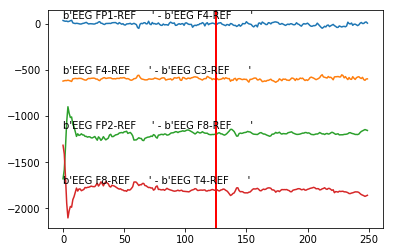

Spike Index:  103


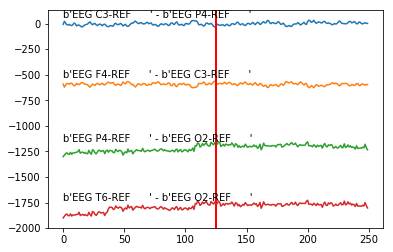

Spike Index:  103


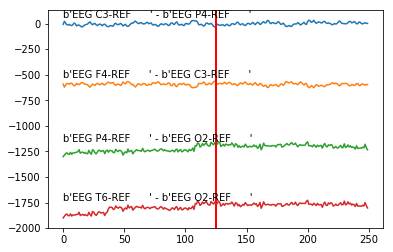

Spike Index:  227


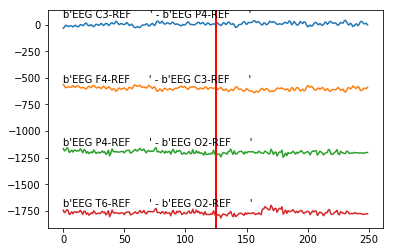

Spike Index:  383


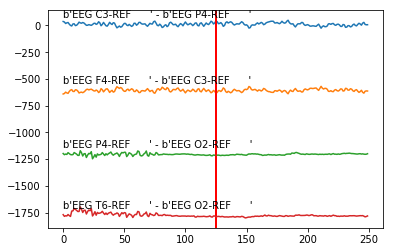

Spike Index:  505


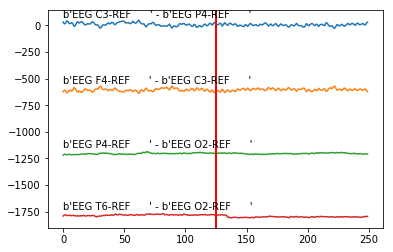

Spike Index:  762


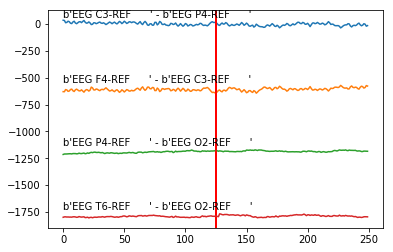

Spike Index:  887


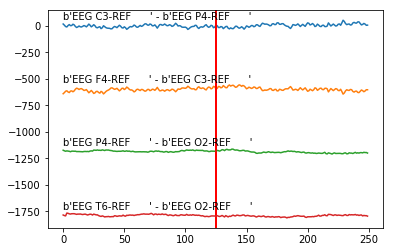

Spike Index:  1116


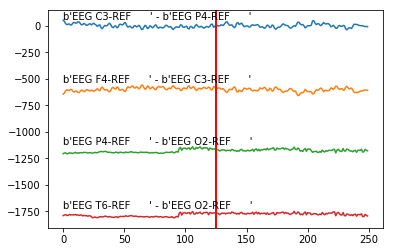

Spike Index:  1211


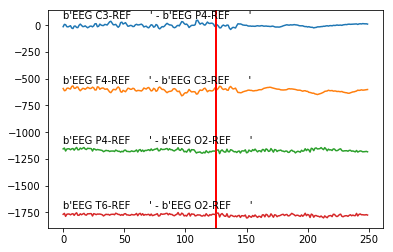

Spike Index:  1305


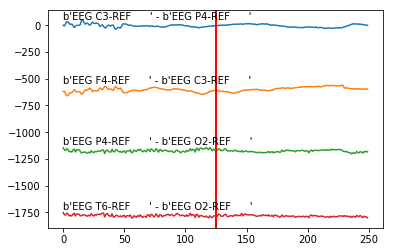

Spike Index:  1419


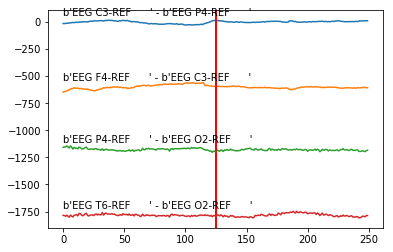

Spike Index:  1524


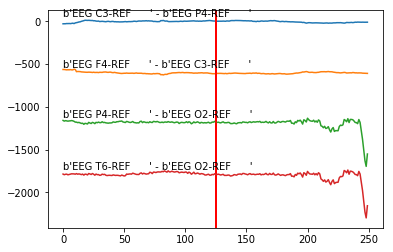

Spike Index:  1900


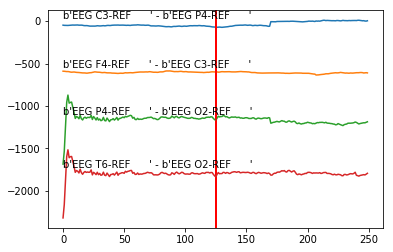

Spike Index:  2030


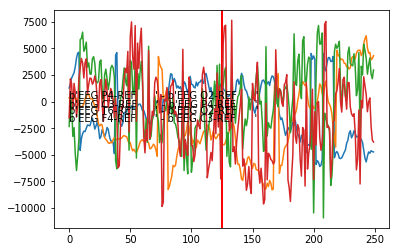

Spike Index:  2153


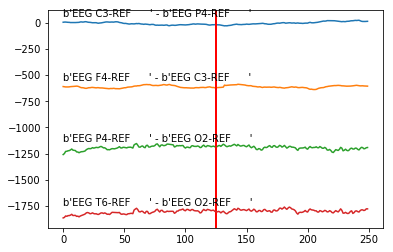

Spike Index:  2488


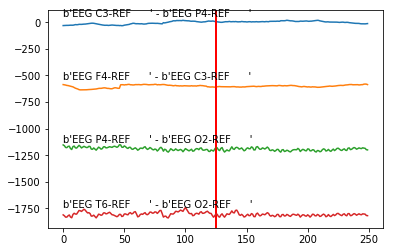

Spike Index:  2876


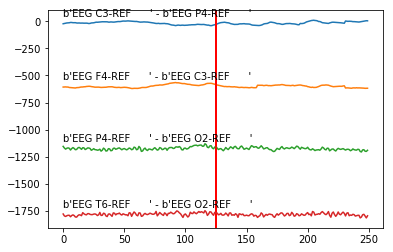

Spike Index:  2968


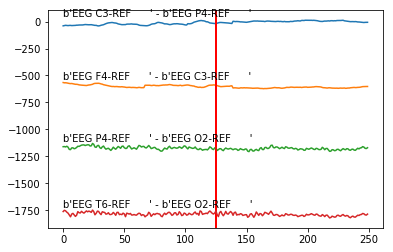

Spike Index:  3138


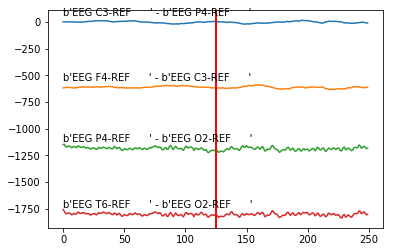

Spike Index:  3463


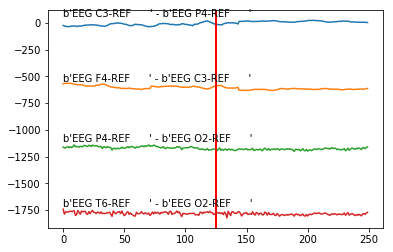

In [212]:
#plotQuadrantSpike(edfObject,quadrantArray,montageArray,quadrantToPlot,indexToPlot,timeSpan)

for i,quadrant in enumerate(finalCandidates):
    for spikeIndex in quadrant[0:20]:
        print("Spike Index: ",spikeIndex)
        plotQuadrantSpike(trainingEDF1,adjacentElectrodeArray,longBipolarMontage,i,spikeIndex,1)
        
    
    
    